In [1]:
#imports
import numpy as np
import pandas as pd
from pybrain.datasets import SequentialDataSet
from itertools import cycle
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import LSTMLayer
from pybrain.supervised import RPropMinusTrainer
import matplotlib.pyplot as plt
from random import randrange
%matplotlib inline

In [2]:
##Error function
def error_in_prediction(predicted_sample, actual_next_sample):
    if type(predicted_sample) is list:
        predicted_sample = np.array(predicted_sample)
    if type(actual_next_sample) is list:
        actual_next_sample = np.array(actual_next_sample)
    error = np.mean(np.square(predicted_sample - actual_next_sample))
    return error

In [3]:
##Plotting function
def gen_state_iteration_plot(lstm_width, state_values, net, ds,\
        it_num, name, save=False, return_error=False):
    if save == True:
        #Required to clear the plots in case the function is used to save
        #the plots
        plt.cla()
    f, axarr = plt.subplots(2, 2, figsize=(10,10))
    for k in range(lstm_width):
        axarr[1,0].plot(state_values[k], label='State '+str(k+1))
        if lstm_width > 1:
            if k == 0:
                master_state = state_values[k]
            else:
                master_state = [sum(x) for x in zip(master_state,\
                    state_values[k])]
    if lstm_width > 1:
        axarr[1,0].plot(master_state, label='adding all states')
    axarr[1,0].legend(prop={'size':6})
    axarr[1,0].set_title('State values after '+str(it_num)+\
            ' training iterations')
    axarr[1,0].set_xlabel('Time steps')
    axarr[1,0].set_ylabel('Magnitude')

    current_input = []
    predicted_sample = []
    actual_next_sample = []
    time =[]
    for sample, target in ds.getSequenceIterator(0):
        current_input.append(sample[0])
        time.append(sample[1])
        predicted_sample.append(net.activate(sample))
        actual_next_sample.append(target)

    #Calculating the error    
    error = error_in_prediction(predicted_sample, actual_next_sample)
    
    #calculating number of points
    numPoints = len(current_input)
    #Plotting the input, predicted output and actual output
    axarr[0,0].plot(range(len(current_input)),current_input, label='Input')
    axarr[0,1].plot(range(len(predicted_sample)),predicted_sample,\
            label='Predicted sample')
    axarr[1,1].plot(range(len(actual_next_sample)),actual_next_sample, \
        label = 'Actual next sample')
    axarr[0,0].set_xlabel('Time steps')
    axarr[0,0].set_ylabel('Magnitude')
    axarr[0,0].set_title('Input')
    axarr[0,1].set_xlabel('Time steps')
    axarr[0,1].set_ylabel('Magnitude')
    axarr[0,1].set_title('Predicted Sample')
    axarr[1,1].set_xlabel('Time steps')
    axarr[1,1].set_ylabel('Magnitude')
    axarr[1,1].set_title('Actual next Sample')
    if save == True:
        plt.savefig('../graphs/Irregular_time_intervals/'+str(len(ds))\
                    +'/'+str(lstm_width)+'/'\
            +name+'_training_iterations_'+str(it_num)+'.png')
        plt.close()
        plt.clf()
    else:
        plt.show()
        
    if return_error == True:
        return error
    else:
        print "Error in prediction :"+str(error)

In [4]:
#Generating the training data for the LSTM
numPoints = 200
x = np.linspace(-10, 10, numPoints)
data = np.sin(x)

In [5]:
numSelPoints = 120
randomIndex = []
while len(randomIndex) < numSelPoints:
    val = randrange(0,len(data))
    if val not in randomIndex:
        randomIndex.append(val)
index = np.sort(randomIndex)
data_irregular = list(data[index])
time_irregular = list(x[index])
delta_t = [0] + list(np.array(time_irregular[1:]) - \
                     np.array(time_irregular[:-1]))

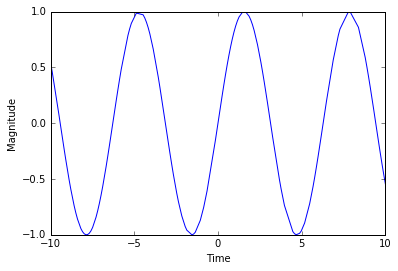

In [6]:
#plotting the time series
plt.plot(time_irregular, data_irregular)
plt.xlabel('Time')
plt.ylabel('Magnitude')

In [7]:
#Creating the sequential dataset for training LSTM
ds = SequentialDataSet(3,1)
for sample, time, del_time, next_sample in zip(data_irregular,\
                        time_irregular, delta_t,\
                        cycle(data_irregular[1:])):
    ds.addSample([sample, time, del_time], next_sample)

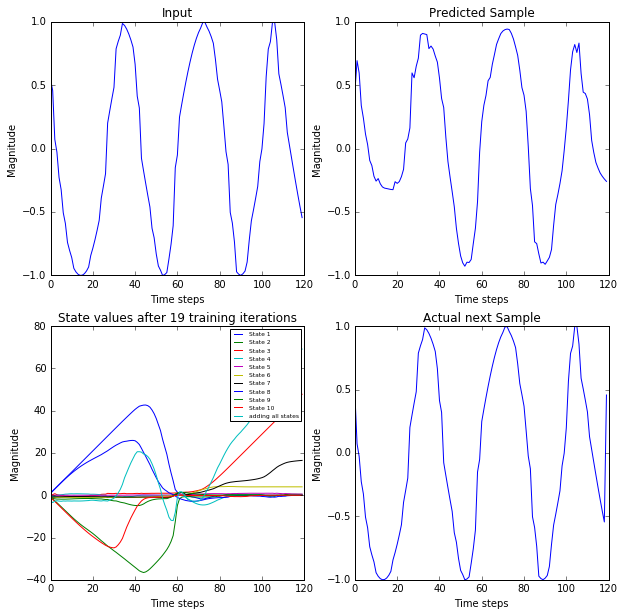

Error in prediction :0.0848512199266


In [8]:
lstmLayerWidth = 10
net = buildNetwork(3,lstmLayerWidth,1, hiddenclass=LSTMLayer, \
                   outputbias=False, recurrent=True)
#Training the network
trainer = RPropMinusTrainer(net, dataset= ds)
train_errors = []
state_values = [[] for k in range(lstmLayerWidth)]
epochs_per_cycle = 1
cycles = 20
epochs = epochs_per_cycle * cycles
for i in xrange(cycles):
    trainer.trainEpochs(epochs_per_cycle)
    train_errors.append(trainer.testOnData())
    epoch = (i+1) * epochs_per_cycle
    #print "\r epoch {}/{}".format(epoch, epochs)
state_values = [[] for k in range(lstmLayerWidth)]
state_val = list(net['hidden0'].state)[:len(ds)]
for state in state_val:
    for k in range(lstmLayerWidth):
        state_values[k].append(state[k])
gen_state_iteration_plot(lstmLayerWidth,\
                state_values, net, ds, i, 'sin')

In [12]:
#Creating folders for storing graphs for a set number of points and
#LSTM layers
import os
graphs_path = os.path.join(os.path.dirname(os.getcwd()),'graphs')
store_path = os.path.join(graphs_path, 'Irregular_time_intervals')
diff = 20
numPointsList = range(diff,numPoints+diff,diff)
maxLayerWidth = 10
layerWidthList = range(1,maxLayerWidth+1)
for num in numPointsList:
    numPath = os.path.join(store_path, str(num))
    if not os.path.isdir(numPath):
        os.makedirs(numPath)
    for layerWidth in layerWidthList:
        layerPath = os.path.join(numPath, str(layerWidth))
        if not os.path.isdir(layerPath):
            os.makedirs(layerPath)

In [21]:
#function for automating the graph generation and error estimation for
#a combination of points in dataset and layerWidth pertaining to LSTM
def train_LSTM(indim, outdim, lstmLayerWidth, numCycles,\
              cycles_per_plot, ds):
    """
    indim - input dimensions
    outdim - output dimensions
    lstmLayerWidth - layer width
    numCycles - number of cycles for training
    cycles_per_plot - number of cycles after which a plot is generated
    ds - training dataset
    """
    net = buildNetwork(indim,lstmLayerWidth,outdim, hiddenclass=LSTMLayer, \
                       outputbias=False, recurrent=True)
    trainer = RPropMinusTrainer(net, dataset= ds)
    error_list = []
    train_errors = []
    epochs_per_cycle = 1
    for i in xrange(numCycles+1):
        trainer.trainEpochs(epochs_per_cycle)
        train_errors.append(trainer.testOnData())
        if i%cycles_per_plot == 0 and i != 0:
            state_values = [[] for k in range(lstmLayerWidth)]
            state_val = list(net['hidden0'].state)[:len(ds)]
            for state in state_val:
                for k in range(lstmLayerWidth):
                    state_values[k].append(state[k])
            error = gen_state_iteration_plot(lstmLayerWidth,\
                state_values, net, ds, i, 'irregular_sin',\
                save=True, return_error=True)
            error_list.append([len(ds), lstmLayerWidth, i, error])
    return error_list

In [1]:
def create_irregular_sin_ds(numPoints, numSelPoints):
    x = np.linspace(-10, 10, numPoints)
    data = np.sin(x)
    randomIndex = []
    while len(randomIndex) < numSelPoints:
        val = randrange(0,len(data))
        if val not in randomIndex:
            randomIndex.append(val)
    index = np.sort(randomIndex)
    data_irregular = list(data[index])
    time_irregular = list(x[index])
    delta_t = [0] + list(np.array(time_irregular[1:]) - \
                     np.array(time_irregular[:-1]))
    #Creating the sequential dataset for training LSTM
    ds = SequentialDataSet(3,1)
    for sample, time, del_time, next_sample in zip(data_irregular,\
                        time_irregular, delta_t,\
                        cycle(data_irregular[1:])):
        ds.addSample([sample, time, del_time], next_sample)
    return ds

In [23]:
result_list = []
numPoints=200
numCycles = 200
cycles_per_plot = 10
for num in numPointsList:
    ds = create_irregular_sin_ds(200, num)
    for layerWidth in layerWidthList:
        results = train_LSTM(3, 1, layerWidth, numCycles,\
                             cycles_per_plot, ds)
        result_list = result_list + results

In [ ]:
result_df = pd.DataFrame(result_list)
result_df.columns = ['numPoints','LSTMWidth',\
                    'numIterations', 'Error']

In [ ]:
result_df.tail()

In [ ]:
#Saving the dataframe
#Append IRR to all irregular interval based results
result_df.to_csv('../outputs/IRR_Error_LSTMWidth_Iterations.csv')